<a href="https://colab.research.google.com/github/Sibgat-Ul/Road_Accidents_Pakistan_Prediction/blob/main/toonsquad_445_7_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Group_Name: ToonSquad
    - Imroz Rahim - 2011129
    - Iffaat Ara Mehnaz - 2031340
    - Sibgat Ul Islam - 2111920

### Import the libraries

In [1]:
import pandas as pd
import numpy as np
from openpyxl.styles.builtins import total

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

import warnings
import nltk

from google.colab import drive
drive.mount('/content/drive')

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download('punkt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
!gzip -d drive/MyDrive/w2v_gn_pretrained.bin.gz && ls

gzip: drive/MyDrive/w2v_gn_pretrained.bin.gz: No such file or directory


In [3]:
!git clone https://github.com/Sibgat-Ul/Road_Accidents_Pakistan_Prediction/ && mv ./Road_Accidents_Pakistan_Prediction/* ./

fatal: destination path 'Road_Accidents_Pakistan_Prediction' already exists and is not an empty directory.


In [4]:
# Importing the dataset

rta_dataset = pd.read_excel('./data/RTA Data 2020 to July 2023.xlsx')

#### Few helper functions:

In [5]:
def get_cat_cols(df: pd.DataFrame) -> list:
    """"
    :param df: Dataframe
    :return: list of column names

    to get categorical columns
    """
    return [col for col in df.columns if df[col].dtype == 'object']

def get_num_cols(df):
    """"
    :param df: Dataframe
    :return: list of column names

    to get num columns
    """
    return [col for col in df.columns if df[col].dtype != 'object']

def get_info(dataset: pd.DataFrame):
    """

    :param dataset: pd.DataFrame
    :return: pd.DataFrame

    Makes a new df with missing and unique values.
    """
    new_df = pd.DataFrame()
    new_df['missing_count'] = dataset.isnull().sum()
    new_df['total'] = dataset.shape[0]
    new_df['missing%'] = (dataset.isnull().sum() / dataset.shape[0])*100
    new_df['n_unique'] = dataset.nunique()
    new_df['type'] = dataset.dtypes
    print(f"Size: {rta_dataset.shape}")
    return new_df

In [6]:
cat_cols = get_cat_cols(rta_dataset)
num_cols = get_num_cols(rta_dataset)

### Some info of the dataset

In [7]:
info_df = get_info(rta_dataset)
info_df

Size: (46189, 25)


,missing_count,total,missing%,n_unique,type
EcYear,0,46189,0.000000,5,object
EcNumber,7211,46189,15.611942,34800,object
CallTime,5956,46189,12.894845,40170,datetime64[ns]
EmergencyArea,1,46189,0.002165,37520,object
TotalPatientsInEmergency,0,46189,0.000000,13,object
Gender,1,46189,0.002165,4,object
Age,1,46189,0.002165,100,float64
HospitalName,21950,46189,47.522137,162,object
Reason,1,46189,0.002165,23940,object
responsetime,5,46189,0.010825,68,float64


In [8]:
# rta_dataset

#### Checking the unique values

In [9]:
target_column = 'PatientStatus'

filtered_cols = rta_dataset[info_df[info_df['n_unique'] < 15].index]
unique_values = [{f'{col}: {rta_dataset[col].unique()}'} for col in filtered_cols.columns]
unique_values

[{"EcYear: [2020 2021 2022 'Hospital' 2023]"},
 {"TotalPatientsInEmergency: [1 2 3 4 8 6 5 10 7 11 9 'Alive & unstable' 15]"},
 {"Gender: ['Male' 'Female' 'Other' nan 0]"},
 {"EducationTitle: ['Intermediate' 'Illetrate' 'Matric' 'Primary' 'Graduation' 'Masters'\n 'Middle' 'PHD' nan 0]"},
 {"InjuryType: ['Minor' 'Single Fracture' 'Head Injury' 'Multiple Fractures'\n 'Spinal Injury' nan]"},
 {"Cause: ['Over Speed' 'Carelessness' 'Tyre Burst' 'U Turn' 'Others' 'Wrong Turn'\n 'One Wheeling' nan]"},
 {"PatientStatus: ['Alive & unstable' 'Alive & stable' 'Dead' nan]"},
 {'BicycleInvovled: [ 0.  1.  2. nan]'},
 {'BikesInvolved: [ 1.  0.  2.  3. 10. nan]'},
 {'BusesInvolved: [ 0.  1.  2. nan]'},
 {'CarsInvolved: [ 0.  1.  2.  3.  4. nan  5.]'},
 {'CartInvovled: [ 0.  1. nan]'},
 {'RickshawsInvolved: [ 0.  1.  2. nan]'},
 {'TractorInvovled: [ 0.  1. nan]'},
 {'TrainsInvovled: [ 0.  1. nan]'},
 {'TrucksInvolved: [ 0.  1.  2.  3. nan]'},
 {'VansInvolved: [ 0.  1.  2.  4.  3. nan]'},
 {'OthersInvo

### Missing value processing
- We will drop the columns with the most missing values
- drop the rows having problematic values (EcYear with Hospital, 0 for Gender)

We have considered dropping rather than filling the values because there are enough samples available.

In [10]:
def drop_garbage_rows(df, col, to_drop):
    df.drop(index=df[df[col] == to_drop].index, axis=0, inplace=True)

drop_garbage_rows(rta_dataset, "EcYear", "Hospital")
drop_garbage_rows(rta_dataset, "Gender", 0)
drop_garbage_rows(rta_dataset, "TotalPatientsInEmergency", 'Alive & unstable')
drop_garbage_rows(rta_dataset, "EducationTitle", 0)

In [11]:
rta_dataset.drop(columns=['HospitalName', 'EcNumber'], inplace=True)

There are 46k data on the dataset, but call time has around 6000 data missing, so if we drop the null values, <br> we would still have at least 40k samples to work with.

In [12]:
rta_dataset.drop(index=rta_dataset[rta_dataset['CallTime'].isnull()].index, inplace=True)

##### More problematic rows

In [13]:
# Another problematic row
rta_dataset[rta_dataset["Gender"].isnull()]

,EcYear,CallTime,EmergencyArea,TotalPatientsInEmergency,Gender,Age,Reason,responsetime,EducationTitle,InjuryType,...,BikesInvolved,BusesInvolved,CarsInvolved,CartInvovled,RickshawsInvolved,TractorInvovled,TrainsInvovled,TrucksInvolved,VansInvolved,OthersInvolved
31355,2022,2022-06-18 13:23:00,"Near 502 Park, Adyala Road Rawalpindi.",2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
rta_dataset.drop(index=rta_dataset[rta_dataset["Gender"].isnull()].index, inplace=True)
rta_dataset.drop(index=rta_dataset[rta_dataset["EmergencyArea"].isnull()].index, inplace=True)
rta_dataset.drop(index=rta_dataset[rta_dataset["responsetime"].isnull()].index, inplace=True)

### No missing values after processing

and we even have enough samples to train the model.

In [15]:
get_info(rta_dataset)

Size: (40227, 23)


,missing_count,total,missing%,n_unique,type
EcYear,0,40227,0.0,4,object
CallTime,0,40227,0.0,40164,datetime64[ns]
EmergencyArea,0,40227,0.0,37237,object
TotalPatientsInEmergency,0,40227,0.0,12,object
Gender,0,40227,0.0,3,object
Age,0,40227,0.0,98,float64
Reason,0,40227,0.0,22010,object
responsetime,0,40227,0.0,68,float64
EducationTitle,0,40227,0.0,8,object
InjuryType,0,40227,0.0,5,object


### Working with the dates

In [16]:
rta_dataset['CallTime'] = pd.DatetimeIndex(rta_dataset['CallTime'])
rta_dataset['CallHour'] = rta_dataset['CallTime'].dt.hour
rta_dataset['CallDayOfWeek'] = rta_dataset['CallTime'].dt.dayofweek
rta_dataset['CallMonth'] = rta_dataset['CallTime'].dt.month
rta_dataset['CallYear'] = rta_dataset['CallTime'].dt.year
rta_dataset.drop(columns=['CallTime', 'CallYear', 'EcYear'], inplace=True)

cat_cols = get_cat_cols(rta_dataset)
num_cols = get_num_cols(rta_dataset)

### Plotting

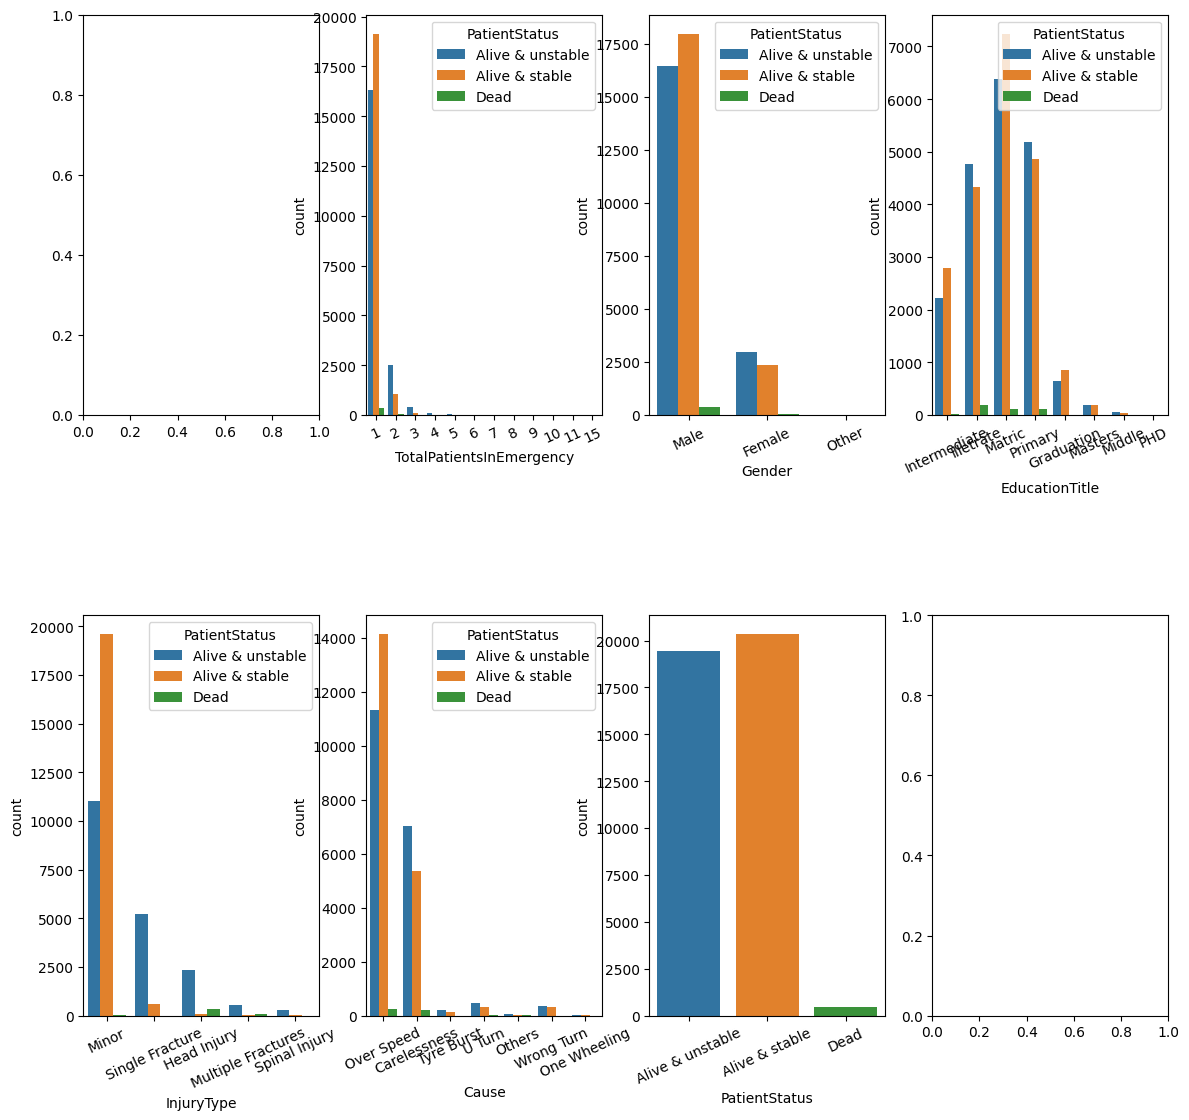

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 13))
plt.subplots_adjust(hspace=.5)

r, c = 0, 0

for col in filtered_cols:
    if col in cat_cols:
        plot = sns.countplot(data=rta_dataset, x=rta_dataset[col], hue='PatientStatus', ax=axes[r, c])
        plot.set_xticklabels(plot.get_xticklabels(), rotation=25)

    if c < 3:
        c = c + 1
    else:
        c = 0
        if r < 1:
            r = r + 1

plt.show()

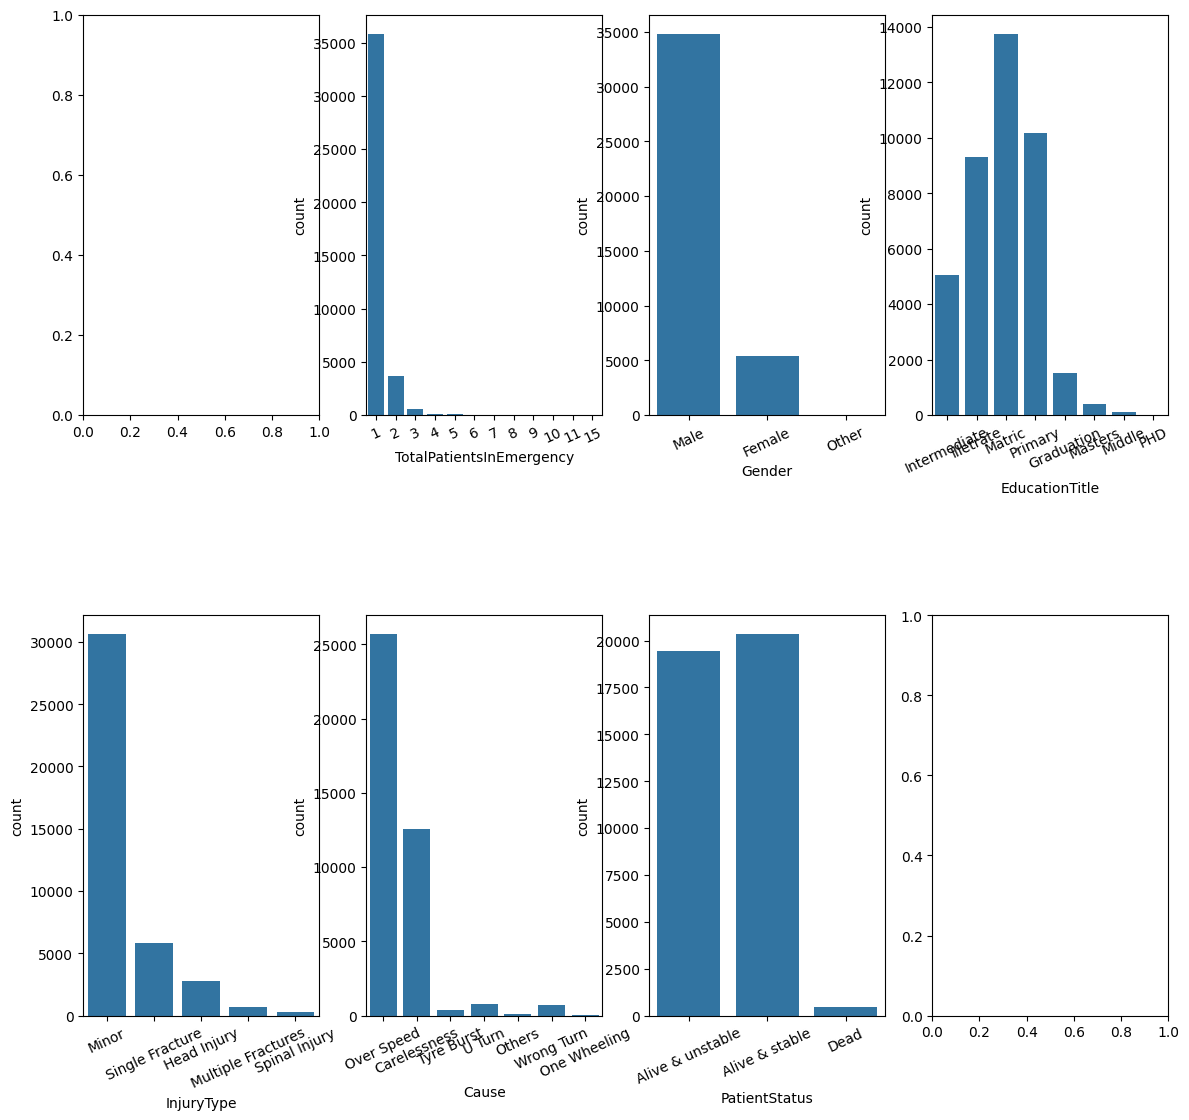

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 13))
plt.subplots_adjust(hspace=.5)

r, c = 0, 0

for col in filtered_cols.columns:
    if col in cat_cols:
        plot = sns.countplot(data=rta_dataset, x=rta_dataset[col], ax=axes[r, c])
        plot.set_xticklabels(plot.get_xticklabels(), rotation=25)
    if c < 3:
        c = c + 1
    else:
        c = 0
        if r < 1:
            r = r + 1

plt.show()

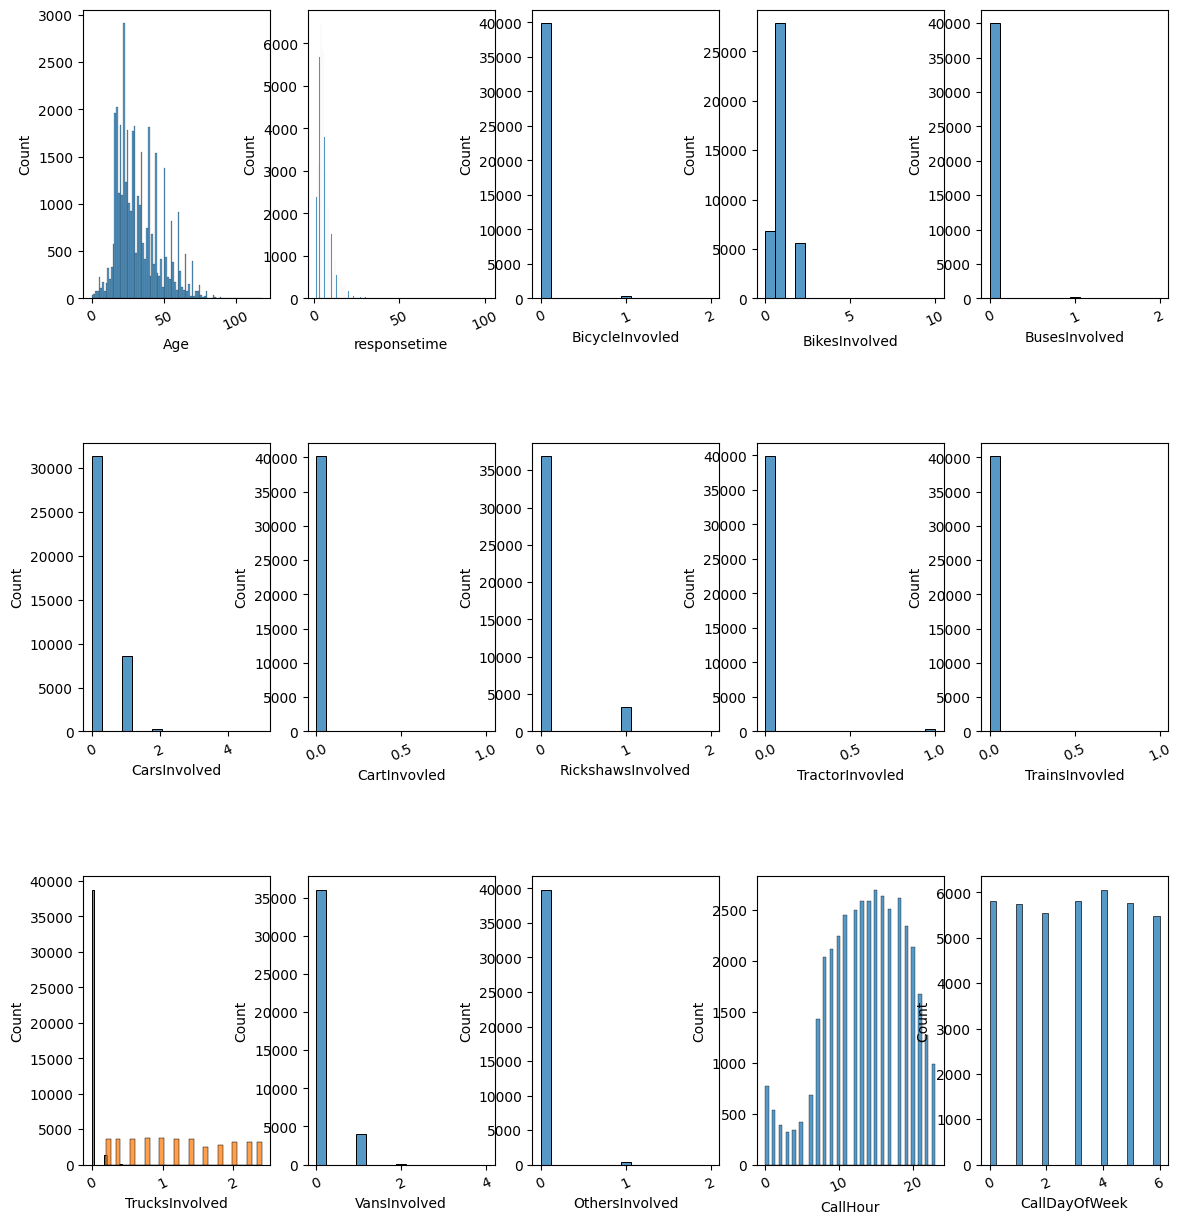

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(14, 15))
plt.subplots_adjust(hspace=.5)

r, c = 0, 0

for col in num_cols:
    plot = sns.histplot(data=rta_dataset, x=col, ax=axes[r, c])
    plot.set_xticklabels(plot.get_xticklabels(), rotation=25)
    if c < 4:
        c = c + 1
    else:
        c = 0
        if r < 2:
            r = r + 1


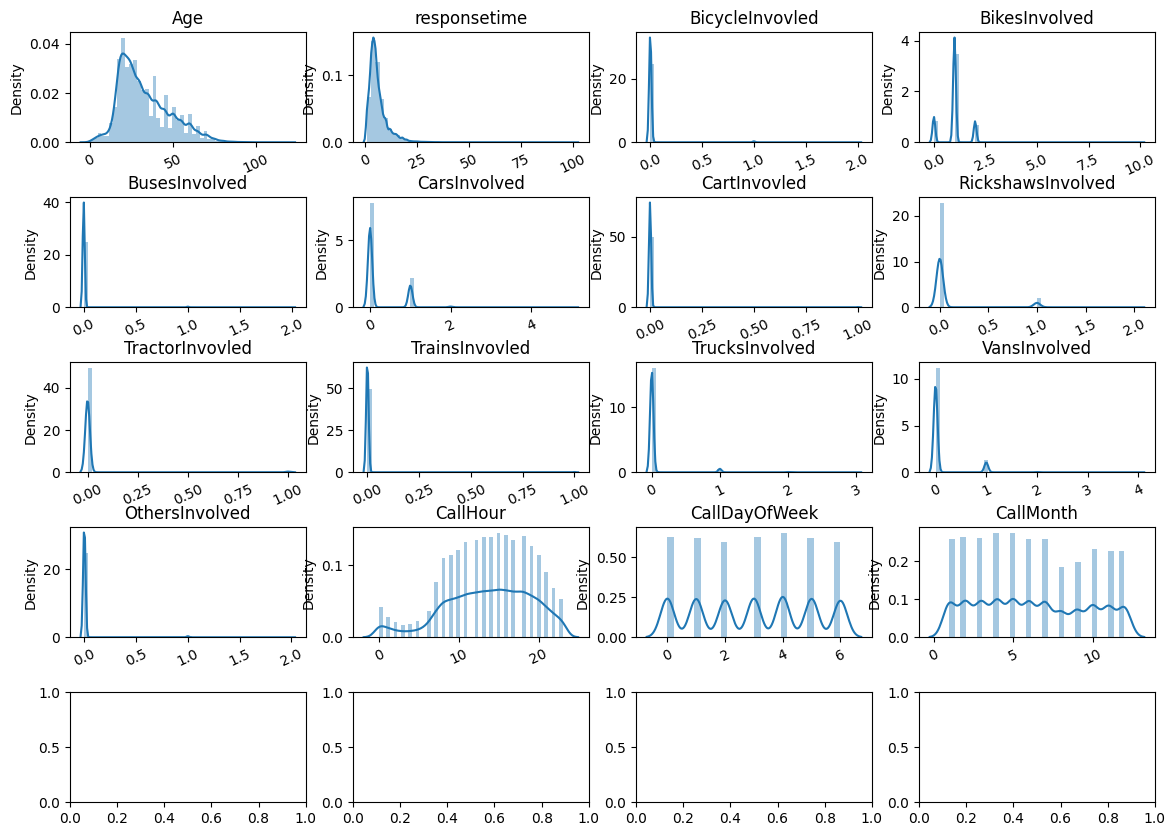

In [20]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(14, 10))
plt.subplots_adjust(hspace=.5)

r, c = 0, 0

for col in num_cols:
    plot = sns.distplot(x=rta_dataset[col], ax=axes[r, c])
    plot.set_xticklabels(plot.get_xticklabels(), rotation=25)
    plot.set_title(col)
    if c < 3:
        c = c + 1
    else:
        c = 0
        if r < 4:
            r = r + 1


<Axes: xlabel='PatientStatus', ylabel='count'>

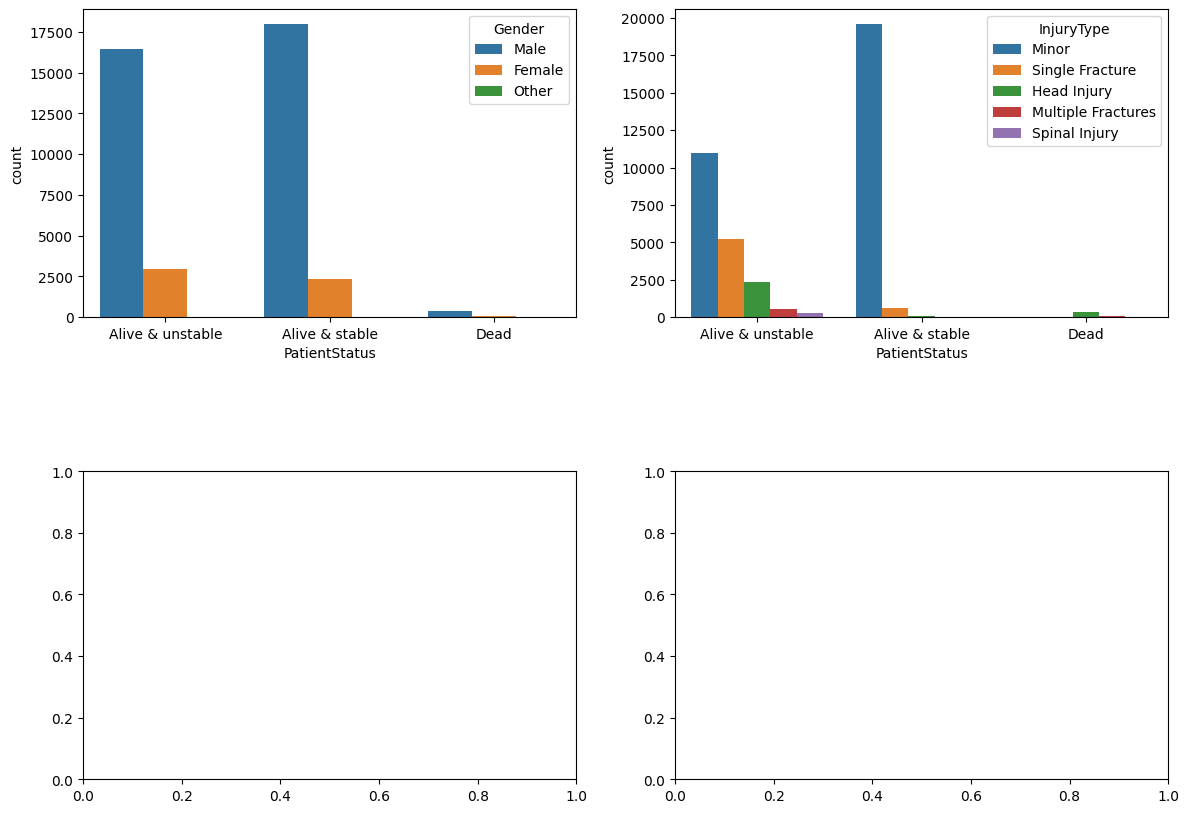

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
plt.subplots_adjust(hspace=.5)

sns.countplot(data=rta_dataset, x='PatientStatus', hue='Gender', ax=axes[0,0])

sns.countplot(data=rta_dataset, x='PatientStatus', hue='InjuryType', ax=axes[0,1])

# plot3 = sns.countplot(data=rta_dataset, x='CallTime', hue='PatientStatus', ax=axes[1,0])
# plot3.set_xticklabels(plot3.get_xticklabels(), rotation=80)

# sns.countplot(data=rta_dataset, x='PatientStatus', hue='Gender', ax=axes[1,1])

<Axes: >

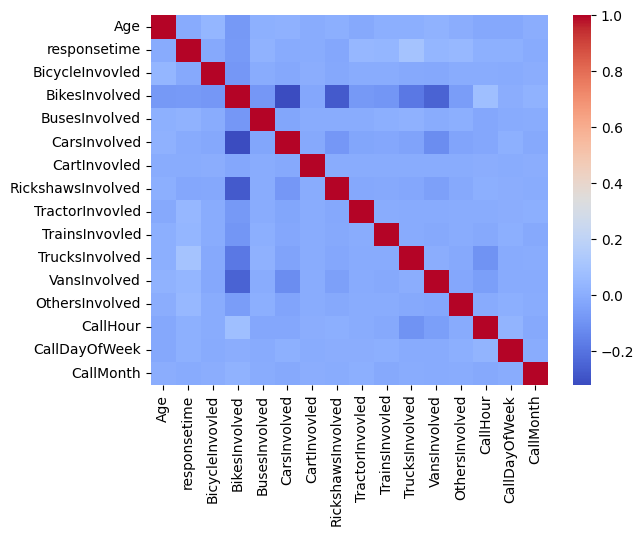

In [22]:
sns.heatmap(rta_dataset[num_cols].corr(), cmap='coolwarm')

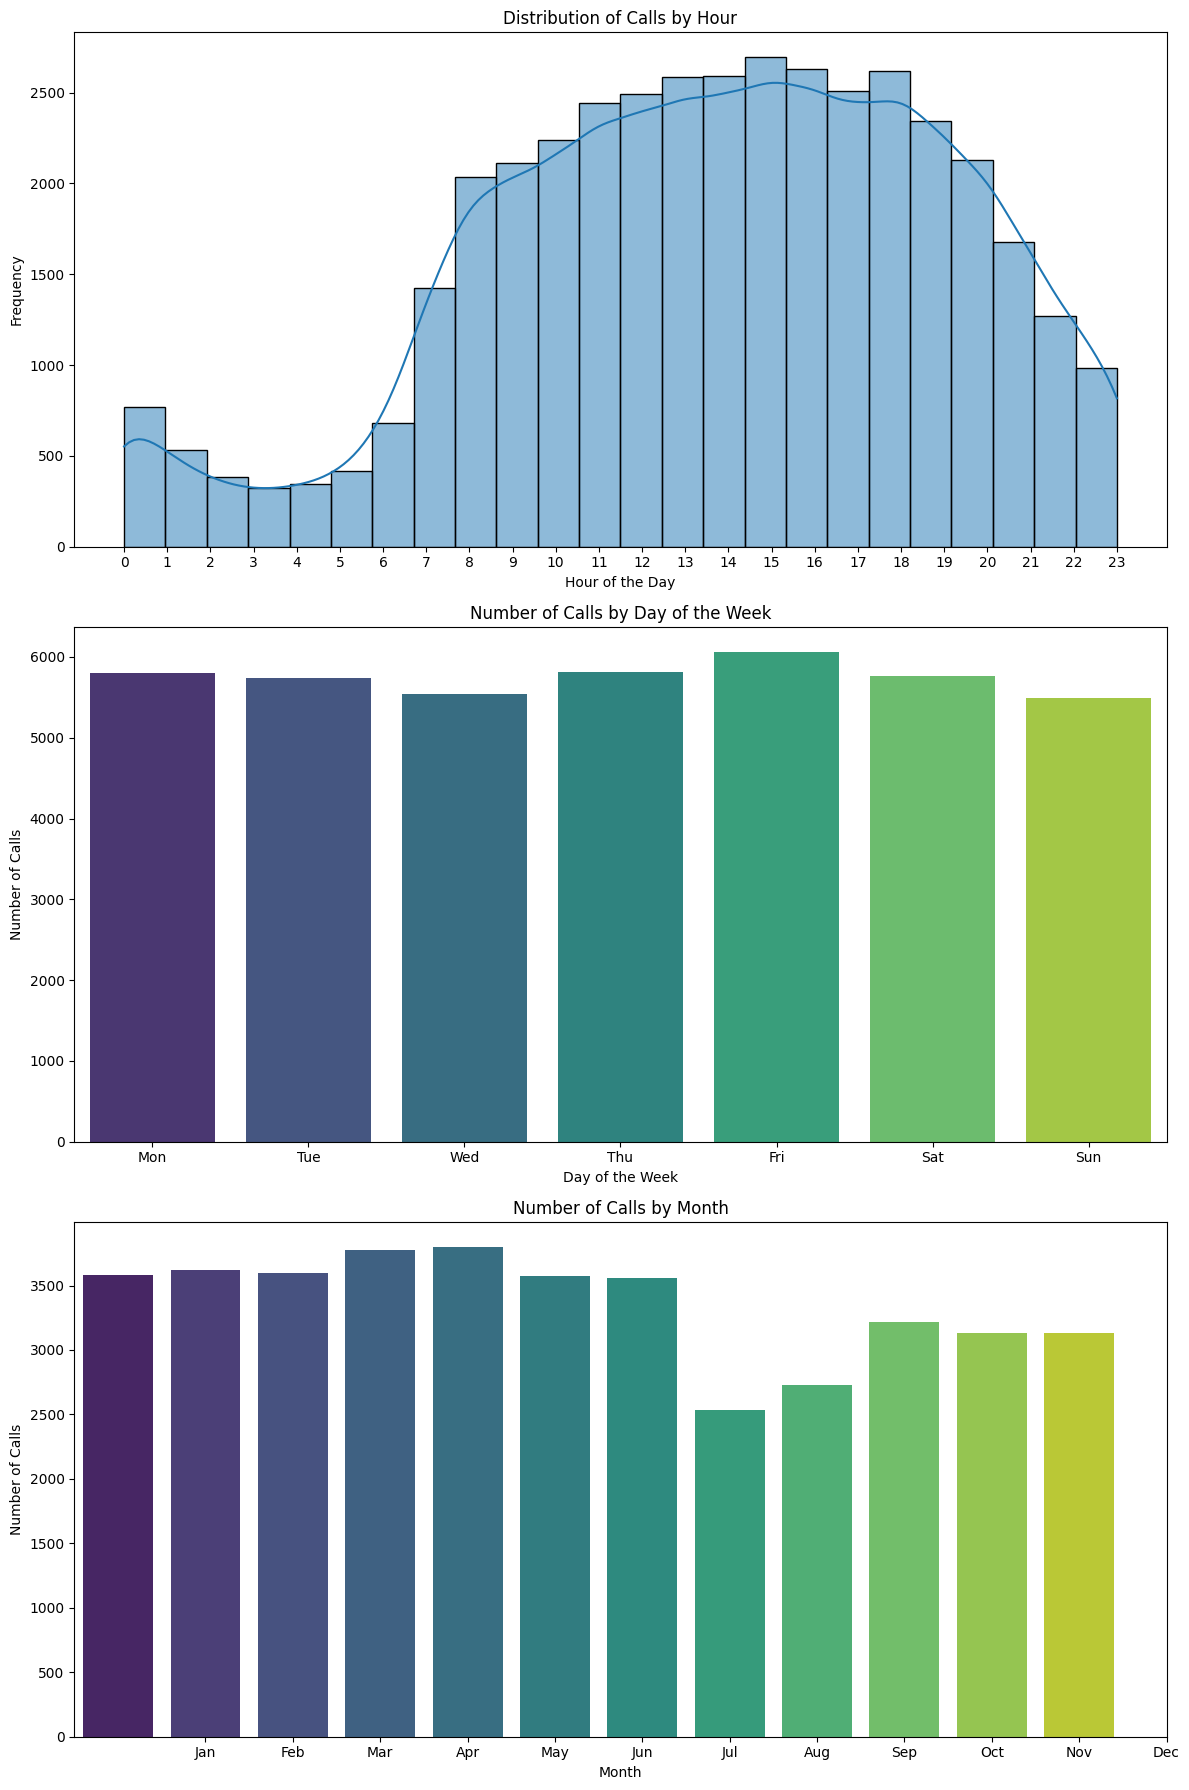

In [23]:
# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot calls by hour
sns.histplot(rta_dataset['CallHour'], bins=24, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Calls by Hour')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(range(0, 24))

# Plot calls by day of the week
sns.countplot(x='CallDayOfWeek', data=rta_dataset, palette='viridis', ax=axes[1])
axes[1].set_title('Number of Calls by Day of the Week')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Number of Calls')
axes[1].set_xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Plot calls by month
sns.countplot(x='CallMonth', data=rta_dataset, palette='viridis', ax=axes[2])
axes[2].set_title('Number of Calls by Month')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Number of Calls')
axes[2].set_xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Adjust layout
plt.tight_layout()
plt.show()

In [24]:
def convert_to_shift(x) -> str:
  hour = x
  if hour >= 1 and hour < 6:
    return 'Mid Night'
  elif hour >= 6 and hour < 12:
    return 'Morning'
  elif hour >= 12 and hour < 18:
    return 'Noon'
  elif hour >= 18 and hour < 21:
    return 'Evening'
  else:
    return 'Night'

def conver_to_season(x) -> str:
  month = x
  if month >= 3 and month < 6:
    return 'Spring'
  elif month >= 6 and month <= 9:
    return 'Monsoon'
  elif month >= 10 and month <= 11:
    return 'Autumn'
  else:
    return 'Winter'

rta_dataset['CallHour'] = rta_dataset['CallHour'].apply(convert_to_shift)
rta_dataset['CallMonth'] = rta_dataset['CallMonth'].apply(conver_to_season)

### Process EmergencyArea

In [25]:
rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].apply(lambda x : x.lower())

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=r".*(rwp|rawalpindi).*",
    value="Rawalpindi",
    regex=True
)

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=
    r".*(gt road|g.t road|g t road).*",
    value="GT Road",
    regex=True
)

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=
    r".*(chowk).*",
    value="Chowk",
    regex=True
)

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=
    r".*(i\.j\.p).*",
    value="IJP Road",
    regex=True
)

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=
    r".*(mandra).*",
    value="Mandra",
    regex=True
)

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=r".*(faizabad|faiza bad).*",
    value="Faizabad",
    regex=True
)

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=r".*(isb).*",
    value="Isb",
    regex=True
)

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=r".*(peshwar).*",
    value="Peshwar",
    regex=True
)

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=r".*(sayidan|syedan).*",
    value="Sayidan",
    regex=True
)

In [26]:
rta_dataset['EmergencyArea'].nunique()

4364

### Looking for the most accident-prone areas

In [27]:
info_df = get_info(rta_dataset)
filtered_cols = rta_dataset[info_df[info_df['n_unique'] < 10].index]
to_encode = [{col: rta_dataset[col].unique()} for col in filtered_cols.columns if col in cat_cols]

to_encode

Size: (40227, 24)


[{'Gender': array(['Male', 'Female', 'Other'], dtype=object)},
 {'EducationTitle': array(['Intermediate', 'Illetrate', 'Matric', 'Primary', 'Graduation',
         'Masters', 'Middle', 'PHD'], dtype=object)},
 {'InjuryType': array(['Minor', 'Single Fracture', 'Head Injury', 'Multiple Fractures',
         'Spinal Injury'], dtype=object)},
 {'Cause': array(['Over Speed', 'Carelessness', 'Tyre Burst', 'U Turn', 'Others',
         'Wrong Turn', 'One Wheeling'], dtype=object)},
 {'PatientStatus': array(['Alive & unstable', 'Alive & stable', 'Dead'], dtype=object)}]

In [28]:
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

danger_zone = [
    {status: Counter(rta_dataset[rta_dataset['PatientStatus'] == status]['EmergencyArea'].values)} for status in to_encode[4]['PatientStatus']
]

In [29]:
top_20_dead_zone = danger_zone[2]['Dead'].most_common()[:20]
top_20_unstable_zone = danger_zone[0]['Alive & unstable'].most_common()[:20]
top_20_stable_zone = danger_zone[1]['Alive & stable'].most_common()[:20]

Text(0.5, 1.0, 'Stable')

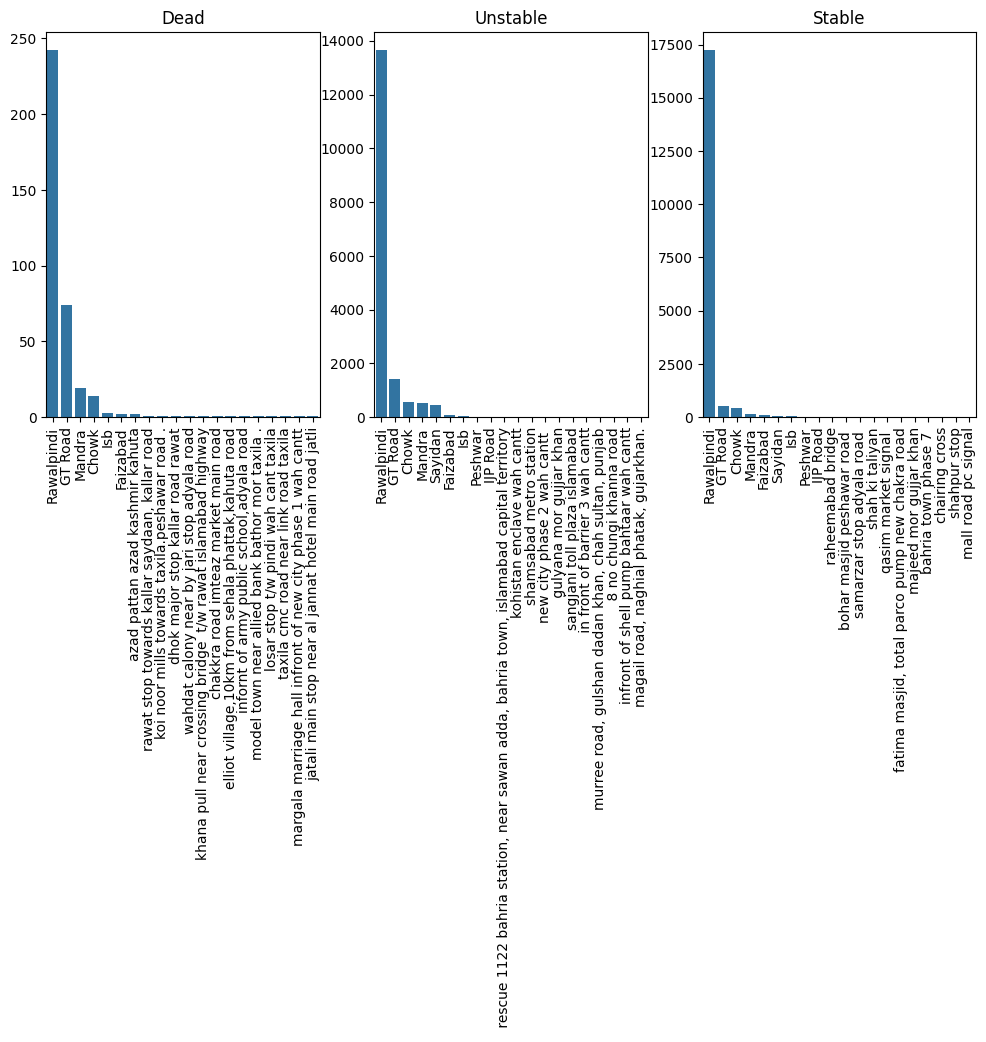

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
plt.subplots_adjust(hspace=.5)
rotate = 90

plot1 = sns.barplot(x=[x[0] for x in top_20_dead_zone], y=[x[1] for x in top_20_dead_zone], ax=axes[0])
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=rotate)
plot1.set_title('Dead')

plot2 = sns.barplot(x=[x[0] for x in top_20_unstable_zone], y=[x[1] for x in top_20_unstable_zone], ax=axes[1])
plot2.set_xticklabels(plot2.get_xticklabels(), rotation=rotate)
plot2.set_title('Unstable')

plot3 = sns.barplot(x=[x[0] for x in top_20_stable_zone], y=[x[1] for x in top_20_stable_zone], ax=axes[2])
plot3.set_xticklabels(plot3.get_xticklabels(), rotation=rotate)
plot3.set_title('Stable')

### Preprocess Reason column with "Same" values

In [31]:
rta_dataset.reset_index(drop=True, inplace=True)
indexes_of_same = rta_dataset[rta_dataset['Reason'] == 'Same'].index
print(indexes_of_same.shape)

for index in indexes_of_same:
    rta_dataset.loc[index, 'Reason'] = rta_dataset.loc[index-1, 'Reason']

print(rta_dataset[rta_dataset['Reason'] == 'Same'].shape)

(472,)
(0, 24)


In [32]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import regex as re

# Initialize wordnet lemmatizer
wnl = WordNetLemmatizer()

rta_dataset['reason_tokenized'] = None

# remove all alphanumeric symbols
for index, row in rta_dataset.iterrows():
    sentence = row['Reason'].lower()
    sentence = re.sub(r'[^a-z]', ' ', sentence)

    tokenized_words = word_tokenize(sentence)
    filtered_sentence = [
        wnl.lemmatize(w) for w in tokenized_words if w not in stopwords.words('english')
    ]

    rta_dataset.loc[index, 'Reason'] = ','.join(list(set(filtered_sentence)))
    rta_dataset['reason_tokenized'].loc[index] = filtered_sentence


freq_reason_of_accident = [
    {status: Counter(rta_dataset[rta_dataset['PatientStatus'] == status]['Reason'].sum().split(','))} for status in to_encode[4]['PatientStatus']
]

#### Looking for the most given reasoning for a accident

In [33]:
top_20_dead = freq_reason_of_accident[2]['Dead'].most_common()[:20]
top_20_unstable = freq_reason_of_accident[0]['Alive & unstable'].most_common()[:20]
top_20_stable = freq_reason_of_accident[1]['Alive & stable'].most_common()[:20]

Text(0.5, 1.0, 'Stable')

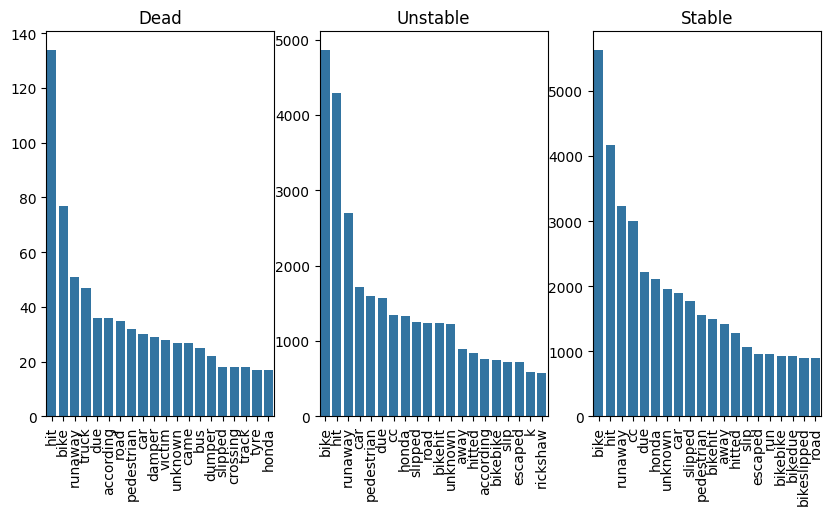

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
plt.subplots_adjust(hspace=.5)
rotate = 90

plot1 = sns.barplot(x=[x[0] for x in top_20_dead], y=[x[1] for x in top_20_dead], ax=axes[0])
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=rotate)
plot1.set_title('Dead')

plot2 = sns.barplot(x=[x[0] for x in top_20_unstable], y=[x[1] for x in top_20_unstable], ax=axes[1])
plot2.set_xticklabels(plot2.get_xticklabels(), rotation=rotate)
plot2.set_title('Unstable')

plot3 = sns.barplot(x=[x[0] for x in top_20_stable], y=[x[1] for x in top_20_stable], ax=axes[2])
plot3.set_xticklabels(plot3.get_xticklabels(), rotation=rotate)
plot3.set_title('Stable')

#### Vectorize the Reason column

In [35]:
import gensim

w2v_model = gensim.models.KeyedVectors.load_word2vec_format('drive/MyDrive/w2v_gn_pretrained.bin', binary=True)

In [36]:
def vectorize(word_list):
  if word_list == None or word_list == []:
    return 0

  vectorized = None

  for word in word_list:
    vectorized = [w2v_model[word] if word in w2v_model else np.zeros(300) for word in word_list]

  vectorized = np.divide(np.sum(vectorized, axis=0), len(vectorized))
  return vectorized

# vectorized = vectorize(['bike', 'hit'])
# print(vectorized)

In [37]:
rta_dataset["reason_tokenized"] = rta_dataset["reason_tokenized"].progress_apply(vectorize)

100%|██████████| 40227/40227 [00:05<00:00, 7112.89it/s]


In [38]:
rta_dataset['reason_tokenized'].head(10)

,reason_tokenized
0,"[-0.09814453, -0.0053100586, -0.099609375, 0.1..."
1,"[0.14257812, -0.011881511, 0.030761719, 0.0401..."
2,"[0.118001305, 0.034627277, 0.020670572, 0.1000..."
3,"[0.15405273, 0.08508301, -0.04486084, -0.00640..."
4,"[0.09667969, 0.057409666, -0.046801757, 0.0850..."
5,"[0.05053711, 0.070373535, -0.06304932, 0.15386..."
6,"[-0.09814453, -0.0053100586, -0.099609375, 0.1..."
7,"[-0.06870814732142858, 0.06883021763392858, -0..."
8,"[-0.0362793, 0.1220459, -0.07458496, 0.0782470..."
9,"[0.17272949, 0.14642334, -0.049743652, 0.06207..."


In [39]:
rta_dataset.drop(index=rta_dataset[rta_dataset["reason_tokenized"].str.len() != 300].index, inplace=True, axis="row")
rta_dataset.reset_index(inplace=True)

In [40]:
print(rta_dataset.shape)
rta_dataset[[i for i in range(300)]] = pd.DataFrame(rta_dataset.reason_tokenized.to_list())
rta_dataset.head()

(38214, 26)


,index,EmergencyArea,TotalPatientsInEmergency,Gender,Age,Reason,responsetime,EducationTitle,InjuryType,Cause,...,290,291,292,293,294,295,296,297,298,299
0,0,Rawalpindi,1,Male,27.0,"slip,bike",10.0,Intermediate,Minor,Over Speed,...,0.063477,0.082275,-0.057552,-0.066620,-0.076904,-0.254395,0.083782,-0.081055,0.031738,-0.149414
1,1,Rawalpindi,1,Male,20.0,"footpath,hit,car",12.0,Illetrate,Minor,Over Speed,...,-0.086751,0.128418,-0.195150,0.002075,0.019531,-0.034668,-0.070068,-0.042643,-0.026021,-0.058268
2,2,Rawalpindi,1,Male,48.0,"rickshaw,hit,car",10.0,Illetrate,Single Fracture,Over Speed,...,-0.214925,0.134928,-0.052246,-0.168945,-0.087891,0.042969,-0.203532,0.118164,-0.068522,-0.027344
3,3,Rawalpindi,1,Male,45.0,"runaway,hit,car",5.0,Matric,Minor,Over Speed,...,-0.127380,0.136963,-0.085632,0.059204,-0.071110,-0.053558,-0.109863,0.122314,-0.083740,-0.075195
4,4,Rawalpindi,1,Male,22.0,"bike,hit,runaway,unknown",5.0,Matric,Single Fracture,Over Speed,...,-0.051758,0.014453,-0.115283,-0.012769,0.019040,-0.127661,-0.002997,0.048437,-0.029785,-0.073730


### Encoding the values

In [41]:
# label encoder
to_map = {
    'InjuryType':{},
    'Cause':{},
    'EducationTitle':{},
    'PatientStatus':{},
    'CallHour':{},
    'CallMonth':{}
  }

for col in to_map:
    unq = rta_dataset[col].unique()
    to_map[col] = {unq[i]: i for i in range(len(unq))}
    rta_dataset[col] = rta_dataset[col].map(to_map[col])

# Onehot Encoding
rta_dataset = pd.get_dummies(rta_dataset, columns=["Gender"], drop_first=True)

In [42]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
rta_dataset["EmergencyArea"] = le.fit_transform(rta_dataset["EmergencyArea"])

In [49]:
rta_dataset.EmergencyArea.info()

<class 'pandas.core.series.Series'>
RangeIndex: 38214 entries, 0 to 38213
Series name: EmergencyArea
Non-Null Count  Dtype
--------------  -----
38214 non-null  int64
dtypes: int64(1)
memory usage: 298.7 KB


<Axes: xlabel='responsetime', ylabel='count'>

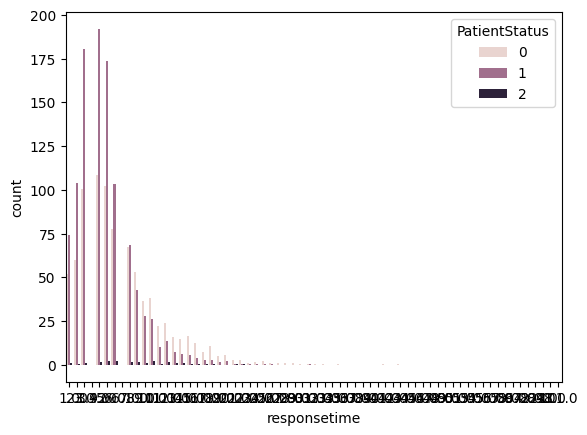

In [44]:
sns.countplot(data=rta_dataset, x='responsetime', hue="PatientStatus")

In [45]:
rta_dataset.drop(columns=["TotalPatientsInEmergency", "Reason", "responsetime", "reason_tokenized"], axis="columns", inplace=True)

In [47]:
rta_dataset.columns

Index([          'index',   'EmergencyArea',             'Age',
        'EducationTitle',      'InjuryType',           'Cause',
         'PatientStatus', 'BicycleInvovled',   'BikesInvolved',
         'BusesInvolved',
       ...
                     292,               293,               294,
                     295,               296,               297,
                     298,               299,     'Gender_Male',
          'Gender_Other'],
      dtype='object', length=323)

In [51]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    rta_dataset.drop(["PatientStatus", "index"], axis="columns"),
    rta_dataset["PatientStatus"],
    test_size=0.2,
    shuffle=True
)

lr_cv = LogisticRegressionCV(cv=5, solver="saga", verbose=42)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

lr_cv.fit(X_train, Y_train)

max_iter reached after 26 seconds
max_iter reached after 24 seconds
max_iter reached after 25 seconds
max_iter reached after 28 seconds
max_iter reached after 26 seconds
max_iter reached after 23 seconds
max_iter reached after 27 seconds
max_iter reached after 23 seconds
max_iter reached after 25 seconds
max_iter reached after 24 seconds


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  4.2min


max_iter reached after 27 seconds
max_iter reached after 23 seconds
max_iter reached after 26 seconds
max_iter reached after 24 seconds
max_iter reached after 26 seconds
max_iter reached after 24 seconds
max_iter reached after 26 seconds
max_iter reached after 24 seconds
max_iter reached after 25 seconds
max_iter reached after 26 seconds


[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  8.4min


max_iter reached after 24 seconds
max_iter reached after 26 seconds
max_iter reached after 24 seconds
max_iter reached after 26 seconds
max_iter reached after 24 seconds
max_iter reached after 25 seconds
max_iter reached after 24 seconds
max_iter reached after 26 seconds
max_iter reached after 24 seconds
max_iter reached after 26 seconds


[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 12.5min


max_iter reached after 24 seconds
max_iter reached after 26 seconds
max_iter reached after 24 seconds
max_iter reached after 26 seconds
max_iter reached after 24 seconds
max_iter reached after 26 seconds
max_iter reached after 24 seconds
max_iter reached after 26 seconds
max_iter reached after 25 seconds
max_iter reached after 27 seconds


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed: 16.7min


max_iter reached after 26 seconds
max_iter reached after 24 seconds
max_iter reached after 26 seconds
max_iter reached after 24 seconds
max_iter reached after 26 seconds
max_iter reached after 24 seconds
max_iter reached after 26 seconds
max_iter reached after 24 seconds
max_iter reached after 26 seconds
max_iter reached after 23 seconds


[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed: 20.9min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed: 20.9min


max_iter reached after 35 seconds


LogisticRegressionCV(cv=5, solver='saga', verbose=42)

In [52]:
from sklearn.metrics import accuracy_score
preds = lr_cv.predict(X_test)
print("accuracy: ", accuracy_score(Y_test, preds))

accuracy:  0.7086222687426403


In [54]:
import pickle

with open('lr_445_v0.pkl', 'wb') as f:
    pickle.dump(lr_cv, f)

In [56]:
!mv lr_445_v0.pkl drive/MyDrive/